# Stock price prediction

This notebook uses artificial neural network, specifically Long Short Term Memory (LSTM), to predict the closing stock price.

In [1]:
import math
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


In [2]:
# Data fetching for the AAPL stock
df = yf.download('AAPL', period="5y")
df.head(6)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-05-04,129.500000,130.570007,128.259995,128.699997,118.437393,50988300
2015-05-05,128.149994,128.449997,125.779999,125.800003,115.768646,49271400
2015-05-06,126.559998,126.750000,123.360001,125.010002,115.041649,72141000
2015-05-07,124.769997,126.080002,124.019997,125.260002,115.753204,43940900
2015-05-08,126.680000,127.620003,126.110001,127.620003,117.934090,55550400
2015-05-11,127.389999,127.559998,125.629997,126.320000,116.732750,42035800


Text(0.5, 1.0, 'AAPL closing price history')

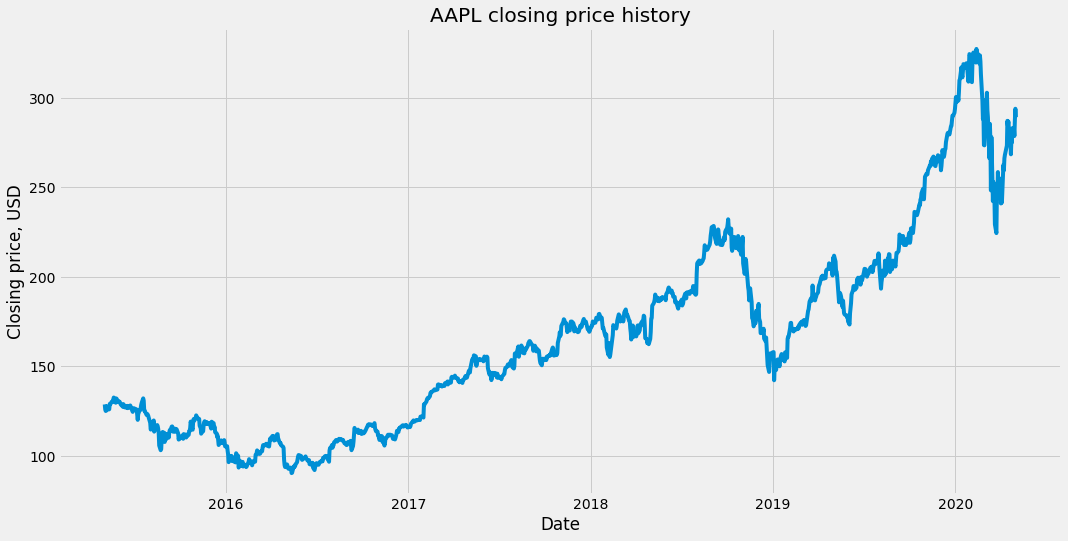

In [3]:
# Plot the closing price
plt.figure(figsize=(16,8))
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Closing price, USD')
plt.title('AAPL closing price history')

In [4]:
# Closing price
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8)

In [5]:
# Create training dataset
train_data = dataset[0:training_data_len, :]

# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train_data = scaler.fit_transform(train_data)

# Split the data
X_train = []
y_train = []

for i in range(60, len(scaled_train_data)):
    X_train.append(scaled_train_data[i-60:i,0])
    y_train.append(scaled_train_data[i,0])

In [6]:
# Convert X_train and y_train to np.arrays
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [7]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [8]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
# Train model
model.fit(X_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
948/948 [==============================] - 44s 47ms/step - loss: 0.0031


In [10]:
# Create the testing dataset
test_data = dataset[training_data_len - 60:, :]
# Create the X_test and y_test
X_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = scaler.transform(X_test)
# Convert the data to np.array
X_test = np.array(X_test)
# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))

In [11]:
# Predicted values
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [12]:
# Evaluate the model. Root mean squred error (RMSE)
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))

/Users/tafintse/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


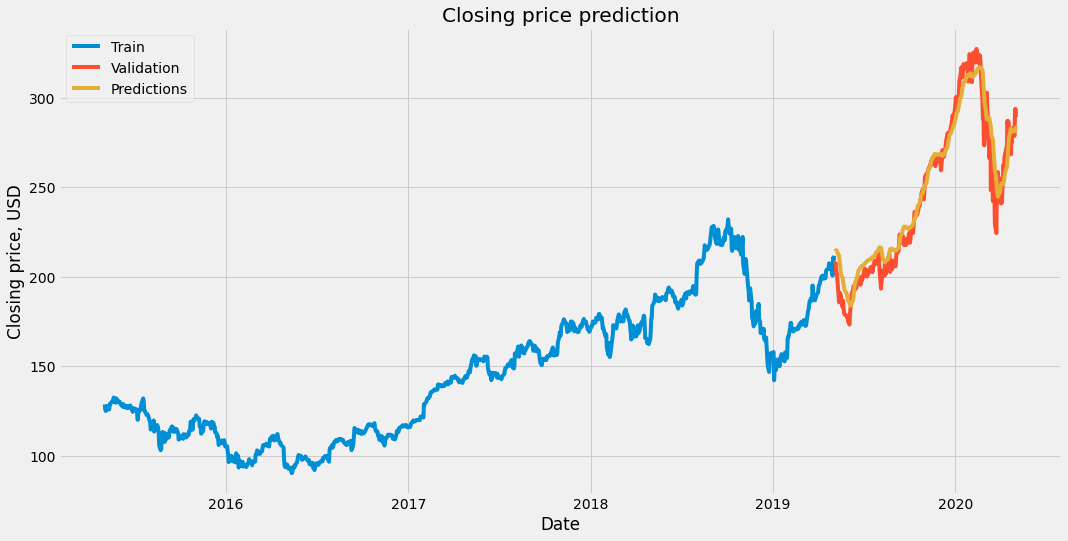

In [13]:
# Plot the data
train = data[0:training_data_len]
valid = data[training_data_len:]
valid['Prediction'] = predictions

plt.figure(figsize=(16,8))
plt.xlabel('Date')
plt.ylabel('Closing price, USD')
plt.title('Closing price prediction')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Prediction']])
plt.legend(['Train', 'Validation', 'Predictions'], loc='best')

In [14]:
valid

,Close,Prediction
Date,,
2019-05-06,208.479996,214.126114
2019-05-07,202.860001,214.822647
2019-05-08,202.899994,214.750107
2019-05-09,200.720001,214.263351
2019-05-10,197.179993,213.336823
...,...,...
2020-04-27,283.170013,281.154114
2020-04-28,278.579987,281.481873
2020-04-29,287.730011,281.494690


In [15]:
# Let's predict the future!
df = yf.download('AAPL', period="5y")
new_df = df.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
pred_price

[*********************100%***********************]  1 of 1 completed


array([[285.57422]], dtype=float32)